In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import tensorflow_probability as tfp
import trieste

import timeit

2021-11-11 11:30:54.087420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 11:30:54.087439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-11 11:30:55.213278: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-11 11:30:55.235977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 11:30:55.236500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

In [2]:
# this space is created by going approximately +-0.2 around parameter values, but not going below 0
# see for original values https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# original values are
# 0.5 1 0.4 0.55 0.5 1 0.5 0.5 0 0.5 0.05 0.05
# and for parameter definition https://github.com/uber-research/TuRBO
search_space = trieste.space.Box(
    [0.3, 0.8, 0.2, 0.35, 0.3, 0.8, 0.3, 0.3, 0.0, 0.3, 0.0,  0.0],
    [0.7, 1.2, 0.6, 0.75, 0.7, 1.2, 0.7, 0.7, 0.2, 0.7, 0.25, 0.25]
)

# lander landed, minimize fuel
FUEL = "FUEL"
# minimize failures, when the lander crashes or times out
FAILURE = "FAILURE"

In [3]:
create_empty_dataset = lambda : trieste.data.Dataset(
                                    tf.zeros((0, search_space.dimension), tf.float64),
                                    tf.zeros((0, 1), tf.float64)
                                )

def lander_observer(x):
    all_datasets = {
        FUEL: create_empty_dataset(),
        FAILURE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        # that's different from constrained optimization
        # because now we want to minimize failure
        # and not penalize by it
        # thus we flip the 1 and 0 values in this dataset
        if result.timeout or result.has_crashed:
            add_data(FAILURE, w, 1.0)
            continue
        else:
            add_data(FAILURE, w, 0.0)

        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(FUEL, w, normalized_fuel)
    
    return all_datasets

In [4]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) < search_space.dimension for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1


print(len(initial_data[FUEL]))
print(len(initial_data[FAILURE]))


DemoHeuristicResult: reward: -23.70, fuel: 7.29, steps: 63.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 8.64, fuel: 15.09, steps: 111.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -61.88, fuel: 62.46, steps: 400.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 19.71, fuel: 15.39, steps: 105.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 257.22, fuel: 26.52, steps: 246.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 20.13, fuel: 18.24, steps: 137.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 46.42, fuel: 21.99, steps: 163.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.62, fuel: 13.17, steps: 105.0, crashed: True, timeout: Fa

In [5]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[0.2]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    FUEL: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[FUEL]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data[FAILURE]),
        **classification_model_config_args
    )
}

In [6]:
class SpecialModelStack(trieste.models.ModelStack):
    """ Special treatment of predict_joint used in sampler
    """
    def __init__(self, models_dict):
        super().__init__((models_dict[FUEL], 1), (models_dict[FAILURE], 1))
        self._models_dict = models_dict

    def predict(self, query_points):
        fuel_mean, fuel_var = self._models_dict[FUEL].predict(query_points)
        failure_mean, failure_var = self._models_dict[FAILURE].predict_y(query_points)
        return tf.concat([fuel_mean, failure_mean], axis=-1), tf.concat([fuel_var, failure_var], axis=-1)


class SpecialBatchMonteCarloExpectedHypervolumeImprovement(trieste.acquisition.function.AcquisitionFunctionBuilder):
    """ The one in trieste is single model, and we need to pass two models and two datasets
    """

    def __init__(self, sample_size: int, *, jitter: float = trieste.utils.misc.DEFAULTS.JITTER):
        """
        :param sample_size: The number of samples from model predicted distribution for
            each batch of points.
        :param jitter: The size of the jitter to use when stabilising the Cholesky decomposition of
            the covariance matrix.
        :raise ValueError (or InvalidArgumentError): If ``sample_size`` is not positive, or
            ``jitter`` is negative.
        """
        tf.debugging.assert_positive(sample_size)
        tf.debugging.assert_greater_equal(jitter, 0.0)

        super().__init__()

        self._sample_size = sample_size
        self._jitter = jitter

    def __repr__(self) -> str:
        """"""
        return (
            f"SpecialBatchMonteCarloExpectedHypervolumeImprovement({self._sample_size!r},"
            f" jitter={self._jitter!r})"
        )

    def prepare_acquisition_function(
        self,
        models,
        datasets,
    ):
        # failure dataset will have all points
        # while fuel only successful ones
        query_points = datasets[FAILURE].query_points
        
        # [0] is because we only need mean and not variance
        means = tf.concat([models[FUEL].predict(query_points)[0], models[FAILURE].predict_y(query_points)[0]], axis=-1)
        _pf = trieste.acquisition.multi_objective.pareto.Pareto(means)
        _reference_pt = trieste.acquisition.multi_objective.pareto.get_reference_point(_pf.front)
        # prepare the partitioned bounds of non-dominated region for calculating of the
        # hypervolume improvement in this area
        _partition_bounds = trieste.acquisition.multi_objective.partition.prepare_default_non_dominated_partition_bounds(_reference_pt, _pf.front)

        sampler = trieste.acquisition.sampler.IndependentReparametrizationSampler(self._sample_size, SpecialModelStack(models))

        return trieste.acquisition.function.batch_ehvi(sampler, self._jitter, _partition_bounds)

In [ ]:
class SpecialSampler(trieste.acquisition.sampler.IndependentReparametrizationSampler):
    def sample(self, at, jitter=0.0):
        tf.debugging.assert_shapes([(at, [..., 1, None])])
        mean, var = self._model.predict(at[..., None, :, :])  # [..., 1, 1, L], [..., 1, 1, L]

        if tf.size(self._eps) == 0:
            self._eps.assign(
                tf.random.normal([self._sample_size, tf.shape(mean)[-1]], dtype=tf.float64)
            )  # [S, L]

        fuel_mean = mean[:, :, 0]
        fuel_var = var[:, :, 0]
        
        failure_mean = mean[:, :, 1]
        failure_var = var[:, :, 1]
        
        failure_mean_y = 
            
        return mean + tf.sqrt(var) * tf.cast(self._eps[:, None, :], var.dtype)  # [..., S, 1, L]
    

        s = super().sample(at, jitter)
        
        fuel_part = s[:, :, 0]
        failure_part = s[:, :, 1]
        
        self._models[1]

    
mean, variance = result.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean - 2 * tf.sqrt(variance), variance)
failure_upper_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean + 2 * tf.sqrt(variance), variance)
    
class IndependentReparametrizationSampler(Sampler):
    r"""
    This sampler employs the *reparameterization trick* to approximate samples from a
    :class:`ProbabilisticModel`\ 's predictive distribution as

    .. math:: x \mapsto \mu(x) + \epsilon \sigma(x)

    where :math:`\epsilon \sim \mathcal N (0, 1)` is constant for a given sampler, thus ensuring
    samples form a continuous curve.
    """

    def __init__(self, sample_size: int, model: ProbabilisticModel):
        """
        :param sample_size: The number of samples to take at each point. Must be positive.
        :param model: The model to sample from.
        :raise ValueError (or InvalidArgumentError): If ``sample_size`` is not positive.
        """
        super().__init__(sample_size, model)

        # _eps is essentially a lazy constant. It is declared and assigned an empty tensor here, and
        # populated on the first call to sample
        self._eps = tf.Variable(
            tf.ones([sample_size, 0], dtype=tf.float64), shape=[sample_size, None]
        )  # [S, 0]

    def sample(self, at: TensorType, jitter=0.0) -> TensorType:
        """
        Return approximate samples from the `model` specified at :meth:`__init__`. Multiple calls to
        :meth:`sample`, for any given :class:`IndependentReparametrizationSampler` and ``at``, will
        produce the exact same samples. Calls to :meth:`sample` on *different*
        :class:`IndependentReparametrizationSampler` instances will produce different samples.

        :param at: Where to sample the predictive distribution, with shape `[..., 1, D]`, for points
            of dimension `D`.
        :return: The samples, of shape `[..., S, 1, L]`, where `S` is the `sample_size` and `L` is
            the number of latent model dimensions.
        :raise ValueError (or InvalidArgumentError): If ``at`` has an invalid shape.
        """
        tf.debugging.assert_shapes([(at, [..., 1, None])])
        mean, var = self._model.predict(at[..., None, :, :])  # [..., 1, 1, L], [..., 1, 1, L]

        if tf.size(self._eps) == 0:
            self._eps.assign(
                tf.random.normal([self._sample_size, tf.shape(mean)[-1]], dtype=tf.float64)
            )  # [S, L]

        return mean + tf.sqrt(var) * tf.cast(self._eps[:, None, :], var.dtype)  # [..., S, 1, L]

In [7]:
from trieste.acquisition.rule import EfficientGlobalOptimization

BATCH_SIZE = 1
ITERATIONS = 300

mc_ehvi = SpecialBatchMonteCarloExpectedHypervolumeImprovement(sample_size=5)
rule = EfficientGlobalOptimization(mc_ehvi, num_query_points=BATCH_SIZE)


bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
start = timeit.default_timer()
result = bo.optimize(ITERATIONS, initial_data, models, rule).final_result.unwrap()
stop = timeit.default_timer()

2021-11-11 11:30:58.308265: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-11-11 11:30:59.433476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-11 11:30:59.454933: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
DemoHeuristicResult: reward: 301.44, fuel: 29.40, steps: 238.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 262.16, fuel: 33.18, steps: 244.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 281.28, fuel: 36.93, steps: 264.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 287.21, fuel: 33.69, steps: 358.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 40.13, fuel: 146.91, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.85, fuel: 20.52, steps: 113.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 2.77, fuel: 34.50, steps: 230.0, crashed: True

DemoHeuristicResult: reward: -204.60, fuel: 13.59, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 186.08, fuel: 28.59, steps: 288.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -53.29, fuel: 126.00, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -8.30, fuel: 8.34, steps: 62.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 274.65, fuel: 21.24, steps: 185.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -70.05, fuel: 17.61, steps: 110.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 269.51, fuel: 24.24, steps: 579.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 228.41, fuel: 30.51, steps: 371.0, crashed: False

DemoHeuristicResult: reward: -26.17, fuel: 8.46, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 241.68, fuel: 39.84, steps: 275.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 22.96, fuel: 14.88, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 273.96, fuel: 16.95, steps: 166.0, crashed: False, timeout: False, is_in_helipad: False, success: False


2021-11-11 11:42:22.449923: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1156000000 exceeds 10% of free system memory.
2021-11-11 11:42:22.579108: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1156000000 exceeds 10% of free system memory.


DemoHeuristicResult: reward: 275.16, fuel: 17.61, steps: 147.0, crashed: False, timeout: False, is_in_helipad: True, success: True


2021-11-11 11:42:29.090637: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1169640000 exceeds 10% of free system memory.
2021-11-11 11:42:29.223575: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1169640000 exceeds 10% of free system memory.


DemoHeuristicResult: reward: 204.04, fuel: 26.52, steps: 502.0, crashed: False, timeout: False, is_in_helipad: False, success: False


2021-11-11 11:42:35.319002: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1183360000 exceeds 10% of free system memory.


DemoHeuristicResult: reward: 237.67, fuel: 18.48, steps: 243.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 292.45, fuel: 21.24, steps: 254.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -56.90, fuel: 14.94, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -62.04, fuel: 15.99, steps: 108.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 13.98, fuel: 15.12, steps: 107.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 55.14, fuel: 27.93, steps: 162.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 240.07, fuel: 20.10, steps: 186.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 263.74, fuel: 17.40, steps: 205.0, crashed: False, t

DemoHeuristicResult: reward: -258.87, fuel: 19.26, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 189.40, fuel: 34.23, steps: 288.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 262.31, fuel: 19.95, steps: 314.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 208.99, fuel: 22.35, steps: 225.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.55, fuel: 6.90, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 220.23, fuel: 25.11, steps: 399.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -31.18, fuel: 7.02, steps: 69.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 10.14, fuel: 16.83, steps: 130.0, crashed: True,

DemoHeuristicResult: reward: 253.04, fuel: 26.22, steps: 355.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -103.03, fuel: 7.56, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 258.88, fuel: 18.00, steps: 203.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -76.55, fuel: 3.33, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 19.74, fuel: 15.24, steps: 112.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -20.89, fuel: 6.33, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 284.12, fuel: 39.54, steps: 389.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 17.49, fuel: 153.51, steps: 1001.0, crashed: False, time

In [8]:
import matplotlib.pyplot as plt

# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

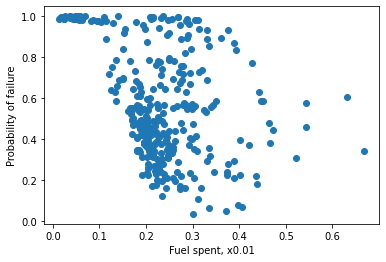

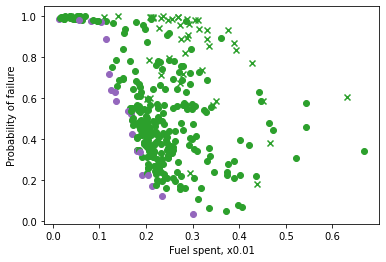

In [9]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[FUEL].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

plt.scatter(objective_model_values, failure_model_values);
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

In [10]:
result.models[FUEL]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.21236806, 1.23458952, 0.93293989, 0.24005349, 0.61307196,
       1.45915103, 0.704547  , 0.487599  , 0.42105967, 0.59587128,
       0.18083984, 0.35379048])>

In [11]:
result.models[FAILURE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([8.25643286, 8.47349992, 1.49696678, 1.69116481, 7.94988557,
       4.9002237 , 0.75391602, 0.42940684, 0.42813201, 0.80711547,
       0.12509855, 0.29530398])>

In [16]:
result.models[FAILURE]._model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,,True,(),float64,5.391766824611656
VGPWrapper.kernel.lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[8.25643286, 8.47349992, 1.49696678..."
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.47505763, 0.97245032, 0.28478337..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGPWrapper.q_mu,Parameter,Identity,,True,"(347, 1)",float64,[[1.43447067e+00...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 347, 347)",float64,"[[[3.85061685e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,347.0


In [12]:
def probability_of_failure(point, n_tries=100):
    if not isinstance(point, np.ndarray):
        point = point.numpy()

    assert point.shape == (int(search_space.dimension),)

    n_failures = 0
    for _ in range(n_tries):
        result = demo_heuristic_lander(lunar_lander.LunarLander(), point, print_result=False)
        if result.timeout or result.has_crashed:
            n_failures += 1
    
    return n_failures / n_tries

In [13]:
from trieste.acquisition.multi_objective.dominance import non_dominated

pf_points, _ = non_dominated(tf.concat([objective_model_values, failure_model_values], axis=1))
pf_input_points = []
for pf_point in pf_points:
    pf_input_point = tf.boolean_mask(all_query_points, tf.equal(objective_model_values, pf_point[0])[:,0])
    if len(pf_input_point) > 1:
        pf_input_point = pf_input_point[0:1, :]
    pf_input_points.append(pf_input_point)
pf_input_points = tf.concat(pf_input_points, axis=0)

In [14]:
failure_actual_values = [probability_of_failure(p) for p in pf_input_points]

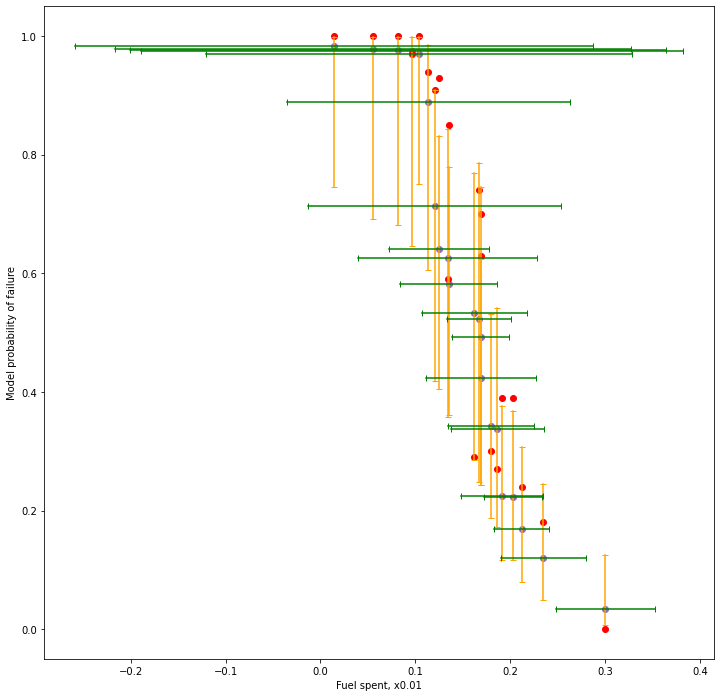

In [15]:
points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)

mean, variance = result.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean - 2 * tf.sqrt(variance), variance)
failure_upper_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean + 2 * tf.sqrt(variance), variance)

mean, variance = result.models[FUEL].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points,
    only_plot_pareto=True,
    figsize=(12,12)
)
plt.scatter(pf_points[:, 0], failure_actual_values, c='r')

for i, (lower, upper) in enumerate(zip(failure_lower_conf_bounds, failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower,upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower,upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Model probability of failure");
plt.show();